<a href="https://colab.research.google.com/github/paras9o9/Dog-Breed-Classifier/blob/main/Dog_Breed_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow matplotlib seaborn opendatasets --quiet

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks, applications
import os, zipfile
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
from google.colab import files
files.upload()  # Upload the kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"paras9o9","key":"26de30ab2ae7f561c1b3222c1e8d118c"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
import opendatasets as od
od.download('https://www.kaggle.com/competitions/dog-breed-identification')

100%|██████████| 691M/691M [00:07<00:00, 101MB/s]



Extracting archive ./dog-breed-identification/dog-breed-identification.zip to ./dog-breed-identification


Total images: 10222
Unique breeds: 120


<Axes: ylabel='breed'>

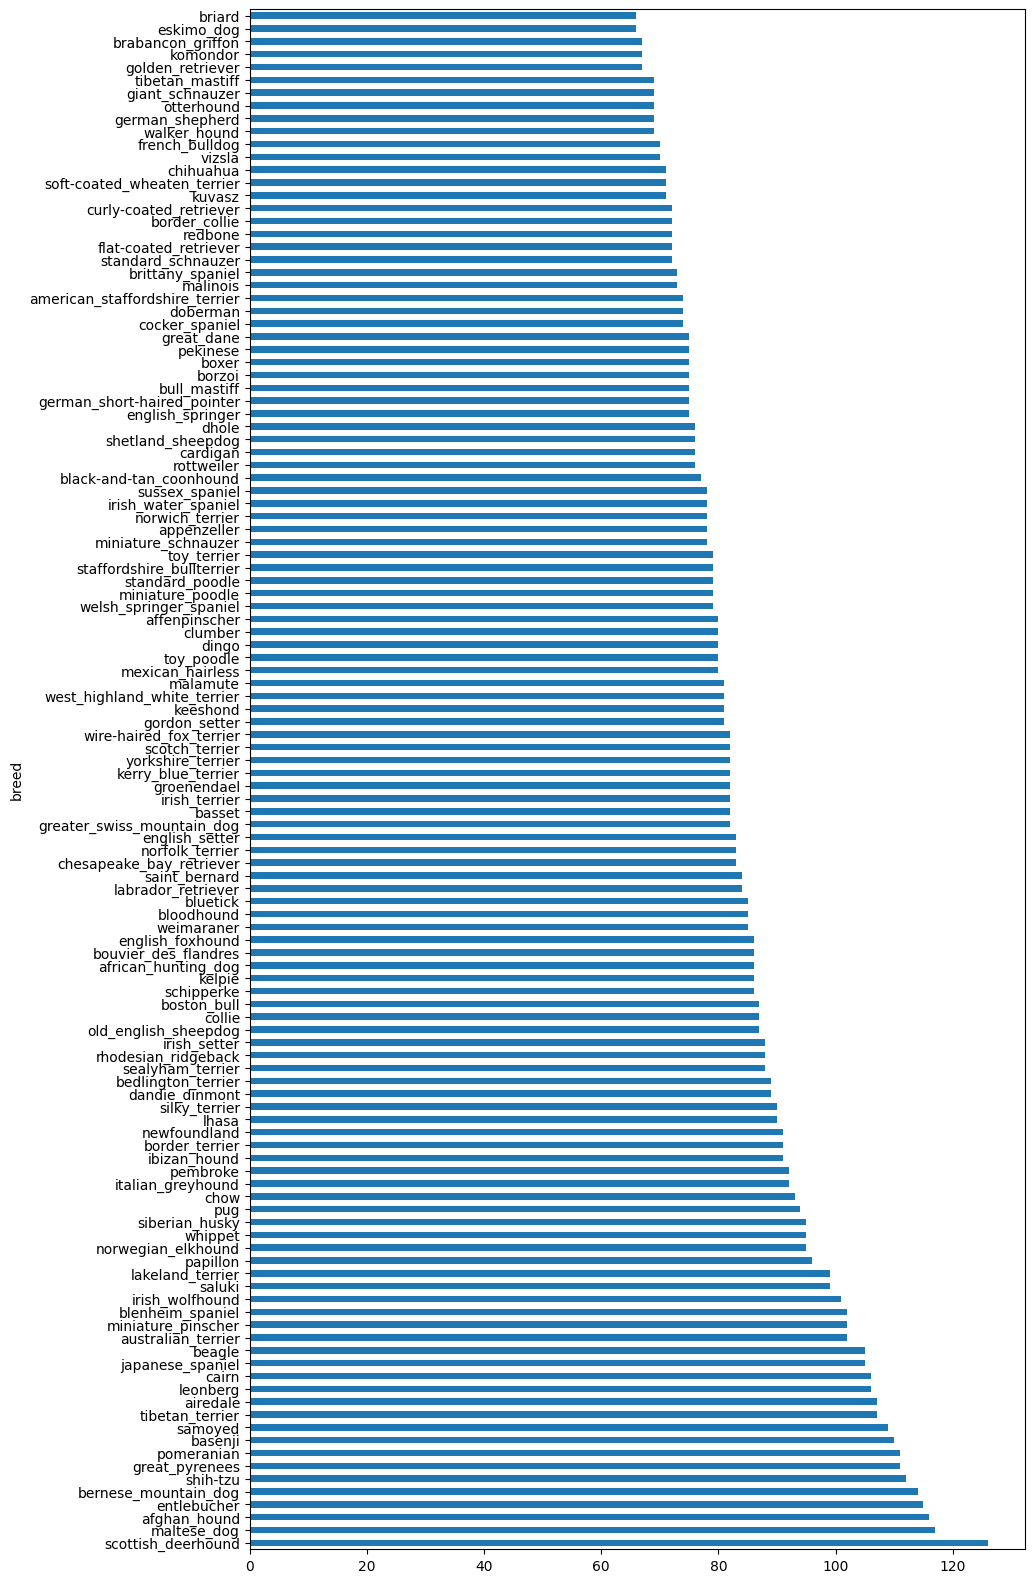

In [7]:
df = pd.read_csv('/content/dog-breed-identification/labels.csv')
print(f"Total images: {len(df)}")
print(f"Unique breeds: {df['breed'].nunique()}")
df['breed'].value_counts().plot(kind='barh', figsize=(10, 20))

In [8]:
from sklearn.model_selection import train_test_split
df['file_path'] = df['id'].apply(lambda x: f"/content/dog-breed-identification/train/{x}.jpg")
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['breed'], random_state=seed)

In [9]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='breed',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='breed',
    target_size=IMG_SIZE,
    class_mode='categorical'
)

Found 8177 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.


In [10]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2 ,2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(df['breed'].nunique(), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
               metrics=['accuracy'])

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 125s 457ms/step - accuracy: 0.0106 - loss: 4.8003 - val_accuracy: 0.0122 - val_loss: 4.7836
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 110s 431ms/step - accuracy: 0.0111 - loss: 4.7841 - val_accuracy: 0.0122 - val_loss: 4.7796
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 110s 430ms/step - accuracy: 0.0127 - loss: 4.7799 - val_accuracy: 0.0122 - val_loss: 4.7771
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 113s 443ms/step - accuracy: 0.0107 - loss: 4.7790 - val_accuracy: 0.0122 - val_loss: 4.7760
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 113s 443ms/step - accuracy: 0.0113 - loss: 4.7781 - val_accuracy: 0.0122 - val_loss: 4.7760
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 113s 441ms/step - accuracy: 0.0121 - loss: 4.7773 - val_accuracy: 0.0122 - val_loss: 4.7758
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 141s 438ms/step - accuracy: 0.0111 - loss: 4.7769 - val_accuracy: 0.0122 - val_loss: 4.7757
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 128s 499ms/step - accuracy: 0.0142 -

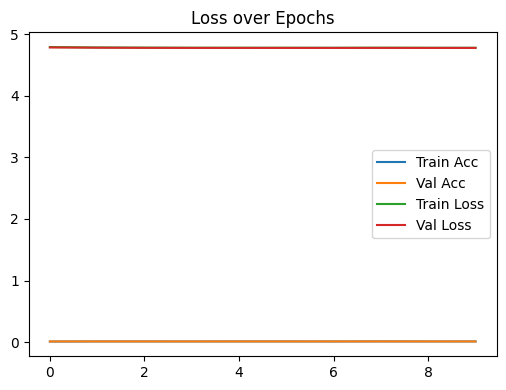

In [12]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.tight_layout()
plt.show()

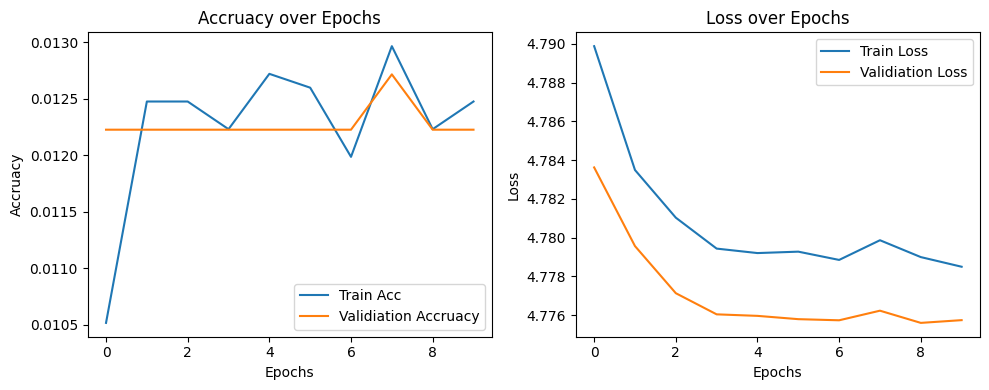

In [13]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Validiation Accruacy')
plt.title('Accruacy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accruacy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validiation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc*100:.2f}%")

64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.0103 - loss: 4.7746
Validation Loss: 4.7755961418151855
Validation Accuracy: 1.22%


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step


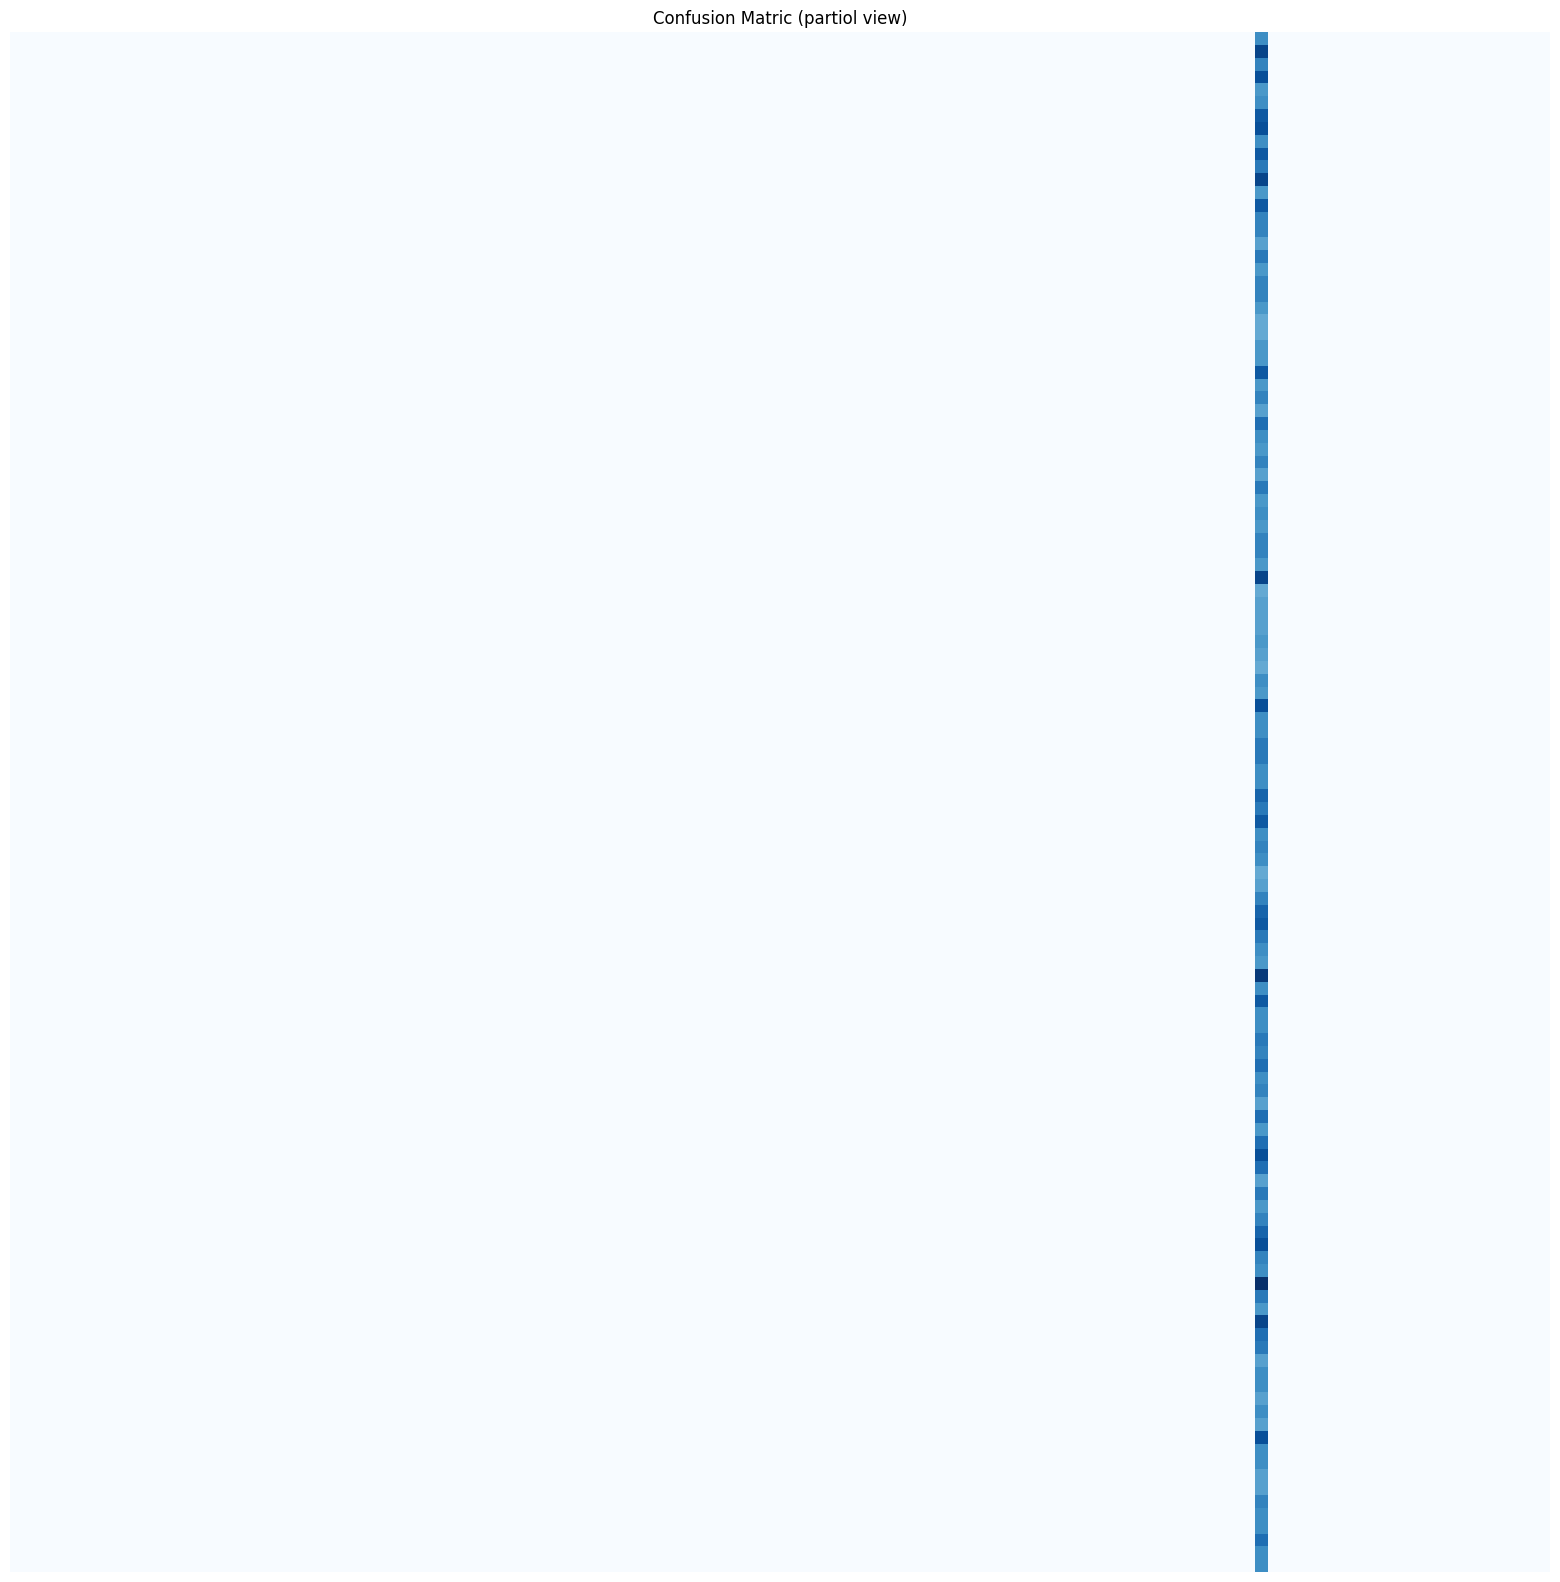

In [15]:
val_preds = model.predict(val_gen)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_gen.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(20, 20))
sns.heatmap(cm, cmap="Blues", square=True, xticklabels=False, yticklabels=False, cbar=False)
plt.title("Confusion Matric (partiol view)")
plt.show()

In [16]:
class_labels = list(val_gen.class_indices.keys())

top_10 = df['breed'].value_counts().index[:10]
filtered_indices = [i for i, label in enumerate(y_true) if class_labels[label] in top_10]

top_10_indices = [class_labels.index(breed) for breed in top_10]

print(classification_report(
    [y_true[i] for i in filtered_indices],
    [y_pred[i] for i in filtered_indices],
    target_names=top_10.tolist(),
    labels=top_10_indices
))

                      precision    recall  f1-score   support

  scottish_deerhound       0.11      1.00      0.20        25
         maltese_dog       0.00      0.00      0.00        24
        afghan_hound       0.00      0.00      0.00        23
         entlebucher       0.00      0.00      0.00        23
bernese_mountain_dog       0.00      0.00      0.00        23
            shih-tzu       0.00      0.00      0.00        23
      great_pyrenees       0.00      0.00      0.00        22
          pomeranian       0.00      0.00      0.00        22
             basenji       0.00      0.00      0.00        22
             samoyed       0.00      0.00      0.00        22

            accuracy                           0.11       229
           macro avg       0.01      0.10      0.02       229
        weighted avg       0.01      0.11      0.02       229



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable= False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(df['breed'].nunique(), activation='softmax')(x)

model_tl = Model(inputs=base_model.input, outputs=output)
model_tl.summary

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<bound method Model.summary of <Functional name=functional_1, built=True>>

In [18]:
model_tl.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

In [19]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_tl = model_tl.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop]
)

Epoch 1/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 131s 471ms/step - accuracy: 0.1988 - loss: 3.7848 - val_accuracy: 0.6528 - val_loss: 1.2539
Epoch 2/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 111s 434ms/step - accuracy: 0.5690 - loss: 1.5487 - val_accuracy: 0.6836 - val_loss: 1.0603
Epoch 3/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 111s 432ms/step - accuracy: 0.6298 - loss: 1.2841 - val_accuracy: 0.6998 - val_loss: 0.9992
Epoch 4/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 110s 429ms/step - accuracy: 0.6663 - loss: 1.1574 - val_accuracy: 0.7154 - val_loss: 0.9349
Epoch 5/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 111s 436ms/step - accuracy: 0.6946 - loss: 1.0482 - val_accuracy: 0.7159 - val_loss: 0.9391
Epoch 6/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 111s 435ms/step - accuracy: 0.6960 - loss: 1.0175 - val_accuracy: 0.7164 - val_loss: 0.9276
Epoch 7/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 109s 426ms/step - accuracy: 0.7117 - loss: 0.9508 - val_accuracy: 0.7164 - val_loss: 0.9430
Epoch 8/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 112s 436ms/step - accuracy: 0.7243 -

In [20]:
val_loss, val_acc = model_tl.evaluate(val_gen)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc*100:.2f}%")

64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.7172 - loss: 0.9120
Validation Loss: 0.927592396736145
Validation Accuracy: 71.64%


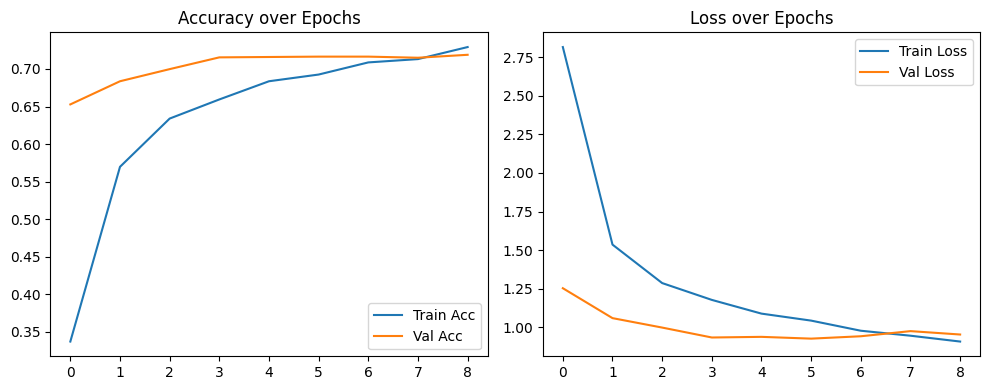

In [21]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_tl.history['accuracy'], label='Train Acc')
plt.plot(history_tl.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_tl.history['loss'], label='Train Loss')
plt.plot(history_tl.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
base_model.trainable = True

for layer in base_model.layers[:-40]:
  layers.trainable = False

print(f"Total layers in base model: {len(base_model.layers)}")

Total layers in base model: 154


In [23]:
from tensorflow.keras.optimizers import Adam

model_tl.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
fine_tune_history = model_tl.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=[early_stop]
)

Epoch 1/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 194s 564ms/step - accuracy: 0.5719 - loss: 1.5379 - val_accuracy: 0.7183 - val_loss: 0.9160
Epoch 2/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 118s 460ms/step - accuracy: 0.6778 - loss: 1.1203 - val_accuracy: 0.7115 - val_loss: 0.9135
Epoch 3/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 120s 467ms/step - accuracy: 0.7018 - loss: 1.0062 - val_accuracy: 0.7193 - val_loss: 0.9137
Epoch 4/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 118s 460ms/step - accuracy: 0.7262 - loss: 0.9163 - val_accuracy: 0.7252 - val_loss: 0.8957
Epoch 5/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 118s 461ms/step - accuracy: 0.7318 - loss: 0.8779 - val_accuracy: 0.7345 - val_loss: 0.8666


In [25]:
val_loss, val_acc = model_tl.evaluate(val_gen)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc*100:.2f}%")

64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.7499 - loss: 0.8528
Validation Loss: 0.8665895462036133
Validation Accuracy: 73.45%


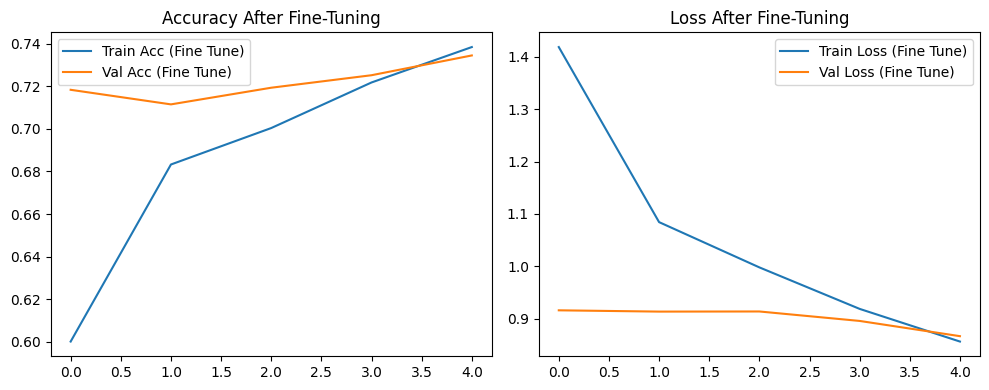

In [26]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(fine_tune_history.history['accuracy'], label='Train Acc (Fine Tune)')
plt.plot(fine_tune_history.history['val_accuracy'], label='Val Acc (Fine Tune)')
plt.legend()
plt.title('Accuracy After Fine-Tuning')

plt.subplot(1, 2, 2)
plt.plot(fine_tune_history.history['loss'], label='Train Loss (Fine Tune)')
plt.plot(fine_tune_history.history['val_loss'], label='Val Loss (Fine Tune)')
plt.legend()
plt.title('Loss After Fine-Tuning')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


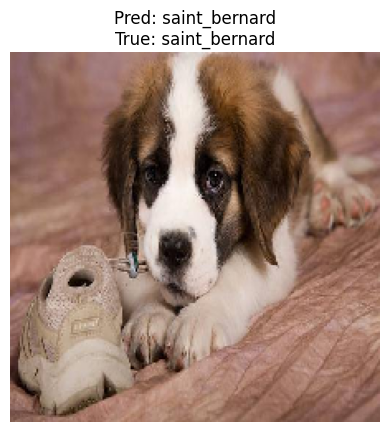

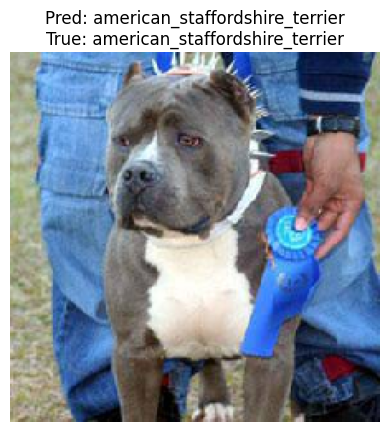

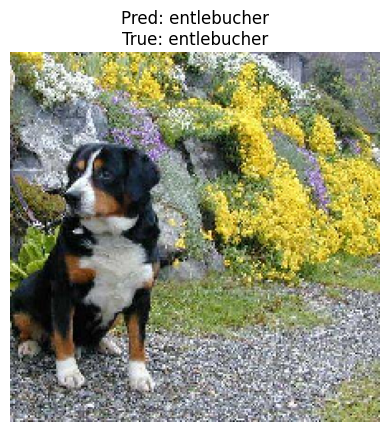

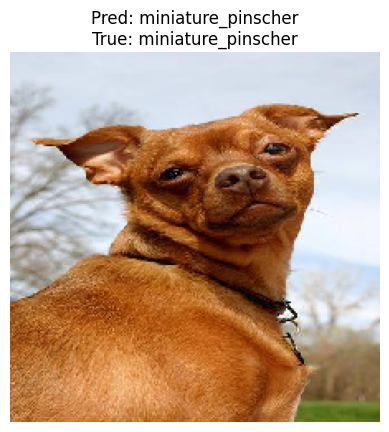

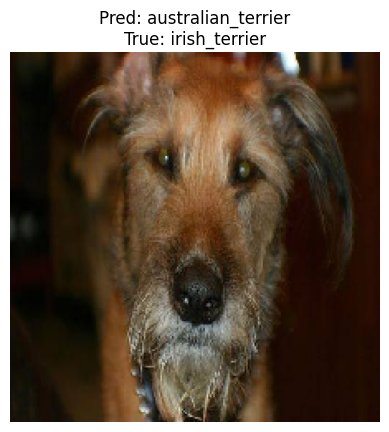

In [27]:
from tensorflow.keras.preprocessing import image

batch = next(val_gen)
imgs, labels = batch[0], batch[1]
preds = model_tl.predict(imgs)
top_preds = np.argmax(preds, axis=1)
true_label = np.argmax(labels, axis=1)

for i in range(5):
  plt.imshow(imgs[i])
  plt.axis('off')
  pred_class = list(train_gen.class_indices.keys())[top_preds[i]]
  true_class = list(train_gen.class_indices.keys())[true_label[i]]
  plt.title(f"Pred: {pred_class}\nTrue: {true_class}")
  plt.show()

In [28]:
model_tl.save("dog_breed_classifier.keras", save_format="keras")

In [29]:
from tensorflow.keras.models import load_model

model = load_model("dog_breed_classifier.keras")

In [30]:
!pip install -q gradio

In [34]:
import tensorflow as tf

model = tf.keras.models.load_model("dog_breed_classifier.keras")

class_names = list(train_gen.class_indices.keys())
print(class_names)

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

In [40]:
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2

def predict_breed(img):
    img = img.resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    pred_index = np.argmax(preds)
    confidence = float(np.max(preds))
    predicted_breed = class_names[pred_index]

    return f"{predicted_breed} ({confidence * 100:.2f}%)"

In [33]:
import gradio as gr

interface = gr.Interface(
    fn=predict_breed,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="🐶 Dog Breed Classifier",
    description="Upload an image of a dog and get its breed prediction.",
    theme="default",
    allow_flagging="never"
)

interface.launch(share=True)

/usr/local/lib/python3.11/dist-packages/gradio/interface.py:416: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a52980ff170ddfcdb0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
